## regularizer を使用
Dropoutの代わりに正則化項を使用して過学習を抑えるモデルを作成する。

LearningRateの調整も行ってみる。

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer


In [2]:
filepath = "../kaggle/house_data/train.csv"

train_data = pd.read_csv(filepath)

train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
X = train_data.copy()
y = X.pop("SalePrice")

num_features = []
for col in X.columns:
    if X[col].dtypes in ["int64", "float64"]:
        num_features.append(col)
print(num_features)

cat_features = []
for col in X.columns:
    if X[col].dtypes=="object":
        cat_features.append(col)
        
print()
print(cat_features)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'Ga

## Pipeline

In [5]:
num_transformer = make_pipeline(SimpleImputer(strategy="constant"),
                                StandardScaler())

cat_transformer = make_pipeline(SimpleImputer(strategy="constant", fill_value="NA"),
                                OneHotEncoder(handle_unknown="ignore", sparse=False))

preprocessor = make_column_transformer((num_transformer, num_features),
                                       (cat_transformer, cat_features))


In [6]:
my_columns = num_features + cat_features


In [9]:
X_select = X[my_columns]

X_select.shape

(1460, 80)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_select, y, train_size=0.7)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)


In [11]:
input_shape = X_train.shape[1]

print(input_shape)

296


## Define model

In [90]:
import tensorflow as tf


model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1024, activation="relu", 
                          kernel_regularizer=tf.keras.regularizers.L2(0.01), 
                          input_shape=(input_shape,)),
    tf.keras.layers.Dense(units=512, activation="relu",
                          kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=256, activation="relu",
                          kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=256, activation="relu",
                          kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(units=1)
])



In [91]:
#adam = tf.keras.optimizers.Adam(learning_rate=0.1)

model.compile(optimizer="adam", 
              loss="MAE")


In [92]:
import matplotlib.pyplot as plt
%matplotlib inline


In [93]:
#early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
 #                                                 min_delta=0.001,
  #                                                restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=256,
                    epochs=200,
                    #callbacks=[early_stopping]
                   )


Epoch 1/200
4/4 [==============================] - 0s 25ms/step - loss: 180872.1250 - val_loss: 181082.0469
Epoch 2/200
4/4 [==============================] - 0s 6ms/step - loss: 180850.1719 - val_loss: 181026.3438
Epoch 3/200
4/4 [==============================] - 0s 6ms/step - loss: 180742.5625 - val_loss: 180780.4688
Epoch 4/200
4/4 [==============================] - 0s 5ms/step - loss: 180315.1094 - val_loss: 179904.9062
Epoch 5/200
4/4 [==============================] - 0s 5ms/step - loss: 178907.8125 - val_loss: 177244.5000
Epoch 6/200
4/4 [==============================] - 0s 5ms/step - loss: 174870.8906 - val_loss: 170089.3594
Epoch 7/200
4/4 [==============================] - 0s 6ms/step - loss: 164504.4844 - val_loss: 152694.2344
Epoch 8/200
4/4 [==============================] - 0s 5ms/step - loss: 140271.3594 - val_loss: 114170.1719
Epoch 9/200
4/4 [==============================] - 0s 6ms/step - loss: 91377.7500 - val_loss: 56713.5977
Epoch 10/200
4/4 [====================

4/4 [==============================] - 0s 6ms/step - loss: 7330.7632 - val_loss: 14894.9541
Epoch 156/200
4/4 [==============================] - 0s 5ms/step - loss: 7331.9380 - val_loss: 14955.2598
Epoch 157/200
4/4 [==============================] - 0s 5ms/step - loss: 7228.7461 - val_loss: 14993.3164
Epoch 158/200
4/4 [==============================] - 0s 5ms/step - loss: 7178.4399 - val_loss: 14896.6211
Epoch 159/200
4/4 [==============================] - 0s 6ms/step - loss: 7175.4146 - val_loss: 14865.6504
Epoch 160/200
4/4 [==============================] - 0s 5ms/step - loss: 7110.1328 - val_loss: 14867.1689
Epoch 161/200
4/4 [==============================] - 0s 5ms/step - loss: 6922.2505 - val_loss: 14957.3535
Epoch 162/200
4/4 [==============================] - 0s 6ms/step - loss: 6964.0820 - val_loss: 14777.6309
Epoch 163/200
4/4 [==============================] - 0s 5ms/step - loss: 6876.8857 - val_loss: 14799.8672
Epoch 164/200
4/4 [==============================] - 0s 6ms/

dict_keys(['loss', 'val_loss'])


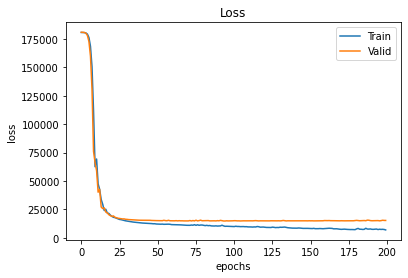

In [89]:
print(history.history.keys())


plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train", "Valid"])
plt.show()

## Test Data

In [94]:
test_file = "../kaggle/house_data/test.csv"

test = pd.read_csv(test_file)

In [95]:
test_data = test[my_columns]

test_data.shape

(1459, 80)

In [96]:
X_test = preprocessor.transform(test_data)

X_test.shape

(1459, 296)

In [97]:
preds = model.predict(X_test)

In [98]:
import itertools

preds_1d = list(itertools.chain.from_iterable(preds))

preds_1d

[120893.555,
 152020.73,
 189256.22,
 198888.86,
 197993.5,
 178243.19,
 184760.39,
 165695.36,
 187045.23,
 130357.51,
 162181.0,
 106493.54,
 105992.164,
 149483.56,
 111349.24,
 368761.66,
 256605.08,
 269935.7,
 277964.28,
 493113.0,
 327103.6,
 211482.34,
 185172.61,
 163723.9,
 182784.25,
 193011.23,
 335075.84,
 241315.62,
 203062.34,
 259737.12,
 198713.25,
 98209.97,
 168071.58,
 289078.66,
 282111.75,
 251590.86,
 191866.84,
 176138.75,
 172350.4,
 170252.05,
 203577.19,
 154396.39,
 287868.47,
 249702.28,
 232450.95,
 202477.0,
 260555.3,
 198755.34,
 167850.75,
 150849.75,
 157381.39,
 181168.69,
 156928.73,
 150343.89,
 193537.62,
 156897.44,
 173397.02,
 124953.57,
 217490.19,
 137678.95,
 146300.56,
 170202.22,
 122556.04,
 121999.836,
 126779.97,
 122145.94,
 112573.45,
 131748.52,
 160015.06,
 202196.4,
 108320.625,
 87981.875,
 143127.72,
 118231.38,
 145442.98,
 112062.305,
 56238.86,
 158670.77,
 249629.92,
 104407.29,
 142493.62,
 139137.45,
 201636.23,
 88883.39,


In [99]:
output = pd.DataFrame({"Id":test.Id,
                       "SalePrice":preds_1d})

output.to_csv("submission_house_price_v5.csv", index=False)